In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/megamax625/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### LeNet

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, padding=2, kernel_size=5)
        self.pool1 = nn.AvgPool2d((2, 2))

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d((2, 2))

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = F.relu(y)
        y = self.pool2(y)
        y = y.flatten(1, -1)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = F.relu(y)
        y = self.fc3(y)
        y = F.relu(y)
        return y

### VGG16

In [3]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        dropout_p = 0.2
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            nn.Dropout(dropout_p),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            nn.Dropout(dropout_p),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*8*8, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_p),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        for layer in self.features:
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
            else:
                x = layer(x)

        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

### Resnet

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, n_features):
        super(ResidualBlock, self).__init__()
        dropout_p = 0.2
        self.conv_block = nn.Sequential(
            nn.Conv2d(n_features, n_features, 3, 1, 1),
            nn.BatchNorm2d(n_features),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),

            nn.Conv2d(n_features, n_features, 3, 1, 1),
            nn.BatchNorm2d(n_features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x) + x


class Resnet(nn.Module):
    def __init__(self, in_ch=3, out_ch=128, n_blocks=16):
        super(Resnet, self).__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.n_blocks = n_blocks


        n_features = 64

        features = [
            nn.Conv2d(in_ch, n_features, 4, 2, 1),
            nn.BatchNorm2d(n_features),
            nn.ReLU(inplace=True)
        ]

        for i in range(self.n_blocks):
            features += [ResidualBlock(n_features)]

        features += [
            nn.Conv2d(n_features, out_ch, 4, 2, 1),
            nn.ReLU(inplace=True)
        ]

        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Linear(self.out_ch * 8 * 8, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 100)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.out_ch * 8 * 8 )
        x = self.classifier(x)

        return x


### Train

In [5]:
def train_model(model, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    accuracy_history = []
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / (i + 1)
        train_losses.append(avg_loss)
        acc = evaluate_model(model)
        accuracy_history.append(acc)
        print(f"Epoch №{epoch + 1}, loss: {avg_loss:.4f}, accuracy: {acc:.2f}%, time spent: {time.time() - epoch_start_time:.2f}s")
    return train_losses, accuracy_history

def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def plot_losses_and_accuracy(model_name, optimizer_names, loss_histories, accuracy_histories):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for optimizer_name, loss_history in zip(optimizer_names, loss_histories):
        plt.plot(loss_history, label=optimizer_name)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Loss for {model_name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    for optimizer_name, accuracy_history in zip(optimizer_names, accuracy_histories):
        plt.plot(accuracy_history, label=optimizer_name)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f'Accuracy for {model_name}')
    plt.legend()


### Optimizers

In [44]:
optimizers = {
    "SGD": lambda model : optim.SGD(model.parameters(), lr=0.03),
    "AdaDelta":  lambda model : optim.Adadelta(model.parameters(), lr=5e-3,rho=0.9),
    "NAG":  lambda model : optim.SGD(model.parameters(), lr=0.03, momentum=0.9, nesterov=True),
    "Adam":  lambda model : optim.Adam(model.parameters(), lr=8e-3)
}

### MNIST

In [8]:
def duplicate_gray_to_rgb(x):
    return x.repeat(3, 1, 1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(duplicate_gray_to_rgb),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [9]:
criterion = nn.CrossEntropyLoss()

def train_optimizer(optimizer_name, modelclass):
    optimizer = optimizers.get(optimizer_name)
    print(f"Training with {optimizer_name} optimizer")
    model = modelclass.to(device)
    train_losses, accuracy_history = train_model(model, criterion, optimizer(model), num_epochs=15)
    if optimizer_name == "SGD":
        index = 0
    elif optimizer_name == "AdaDelta":
        index = 1
    elif optimizer_name == "NAG":
        index = 2
    elif optimizer_name == "Adam":
        index = 3
    all_loss_histories[index] = train_losses
    all_accuracy_histories[index] = accuracy_history
    all_optimizer_names[index] = optimizer_name
    accuracy = accuracy_history[-1]
    print(f"{optimizer_name} optimizer, final accuracy: {accuracy:.2f}%\n")

In [10]:
all_loss_histories = [None, None, None, None]
all_accuracy_histories = [None, None, None, None]
all_optimizer_names = [None, None, None, None]

### Train LeNet

In [11]:
train_optimizer("SGD", LeNet())

Training with SGD optimizer


Epoch №1, loss: 1.3730, accuracy: 81.80%, time spent: 9.56s
Epoch №2, loss: 0.2528, accuracy: 96.14%, time spent: 9.27s
Epoch №3, loss: 0.1184, accuracy: 97.11%, time spent: 9.26s
Epoch №4, loss: 0.0878, accuracy: 97.08%, time spent: 9.50s
Epoch №5, loss: 0.0709, accuracy: 97.79%, time spent: 9.43s
Epoch №6, loss: 0.0609, accuracy: 98.20%, time spent: 9.47s
Epoch №7, loss: 0.0525, accuracy: 97.83%, time spent: 12.84s
Epoch №8, loss: 0.0461, accuracy: 98.52%, time spent: 18.20s
Epoch №9, loss: 0.0402, accuracy: 98.19%, time spent: 15.78s
Epoch №10, loss: 0.0368, accuracy: 98.81%, time spent: 14.87s
Epoch №11, loss: 0.0341, accuracy: 98.84%, time spent: 23.12s
Epoch №12, loss: 0.0309, accuracy: 98.51%, time spent: 28.71s
Epoch №13, loss: 0.0281, accuracy: 98.85%, time spent: 17.97s
Epoch №14, loss: 0.0259, accuracy: 98.71%, time spent: 16.19s
Epoch №15, loss: 0.0241, accuracy: 98.45%, time spent: 16.97s
SGD optimizer, final accuracy: 98.45%



In [30]:
train_optimizer("AdaDelta", LeNet())

Training with AdaDelta optimizer
Epoch №1, loss: 2.3011, accuracy: 11.35%, time spent: 13.77s
Epoch №2, loss: 2.2862, accuracy: 11.36%, time spent: 11.78s
Epoch №3, loss: 2.1285, accuracy: 51.52%, time spent: 11.58s
Epoch №4, loss: 1.2267, accuracy: 78.58%, time spent: 11.73s
Epoch №5, loss: 0.6737, accuracy: 83.46%, time spent: 11.81s
Epoch №6, loss: 0.5218, accuracy: 86.36%, time spent: 13.32s
Epoch №7, loss: 0.4496, accuracy: 87.84%, time spent: 15.08s
Epoch №8, loss: 0.4045, accuracy: 88.70%, time spent: 12.05s
Epoch №9, loss: 0.3727, accuracy: 89.87%, time spent: 11.91s
Epoch №10, loss: 0.3481, accuracy: 90.29%, time spent: 12.13s
Epoch №11, loss: 0.3275, accuracy: 90.93%, time spent: 11.90s
Epoch №12, loss: 0.3109, accuracy: 91.34%, time spent: 12.12s
Epoch №13, loss: 0.2957, accuracy: 91.60%, time spent: 11.90s
Epoch №14, loss: 0.2825, accuracy: 92.07%, time spent: 11.87s
Epoch №15, loss: 0.2702, accuracy: 92.46%, time spent: 11.89s
AdaDelta optimizer, final accuracy: 92.46%



In [13]:
train_optimizer("NAG", LeNet())

Training with NAG optimizer
Epoch №1, loss: 0.9630, accuracy: 69.28%, time spent: 10.44s
Epoch №2, loss: 0.3884, accuracy: 89.00%, time spent: 10.45s
Epoch №3, loss: 0.2750, accuracy: 89.44%, time spent: 12.42s
Epoch №4, loss: 0.2624, accuracy: 89.42%, time spent: 11.44s
Epoch №5, loss: 0.2557, accuracy: 89.62%, time spent: 12.74s
Epoch №6, loss: 0.2506, accuracy: 89.43%, time spent: 11.74s
Epoch №7, loss: 0.2479, accuracy: 89.67%, time spent: 10.30s
Epoch №8, loss: 0.2463, accuracy: 89.61%, time spent: 15.99s
Epoch №9, loss: 0.2447, accuracy: 89.69%, time spent: 12.63s
Epoch №10, loss: 0.2415, accuracy: 89.67%, time spent: 14.52s
Epoch №11, loss: 0.2397, accuracy: 89.57%, time spent: 17.53s
Epoch №12, loss: 0.2397, accuracy: 89.61%, time spent: 14.78s
Epoch №13, loss: 0.2385, accuracy: 89.70%, time spent: 20.88s
Epoch №14, loss: 0.2359, accuracy: 89.74%, time spent: 18.17s
Epoch №15, loss: 0.2362, accuracy: 89.42%, time spent: 16.15s
NAG optimizer, final accuracy: 89.42%



In [50]:
train_optimizer("Adam", LeNet())

Training with Adam optimizer
Epoch №1, loss: 0.8289, accuracy: 68.36%, time spent: 16.87s
Epoch №2, loss: 0.6796, accuracy: 79.25%, time spent: 15.53s
Epoch №3, loss: 0.5140, accuracy: 88.06%, time spent: 14.20s
Epoch №4, loss: 0.2917, accuracy: 88.61%, time spent: 13.33s
Epoch №5, loss: 0.2840, accuracy: 88.85%, time spent: 13.26s
Epoch №6, loss: 0.2789, accuracy: 88.84%, time spent: 13.71s
Epoch №7, loss: 0.2757, accuracy: 88.95%, time spent: 13.48s
Epoch №8, loss: 0.2735, accuracy: 88.69%, time spent: 13.11s
Epoch №9, loss: 0.1561, accuracy: 98.73%, time spent: 13.52s
Epoch №10, loss: 0.0634, accuracy: 98.68%, time spent: 13.53s
Epoch №11, loss: 0.0435, accuracy: 98.36%, time spent: 13.36s
Epoch №12, loss: 0.0522, accuracy: 98.62%, time spent: 13.46s
Epoch №13, loss: 0.0440, accuracy: 98.48%, time spent: 13.33s
Epoch №14, loss: 0.0530, accuracy: 97.51%, time spent: 13.29s
Epoch №15, loss: 0.0438, accuracy: 98.65%, time spent: 13.46s
Adam optimizer, final accuracy: 98.65%



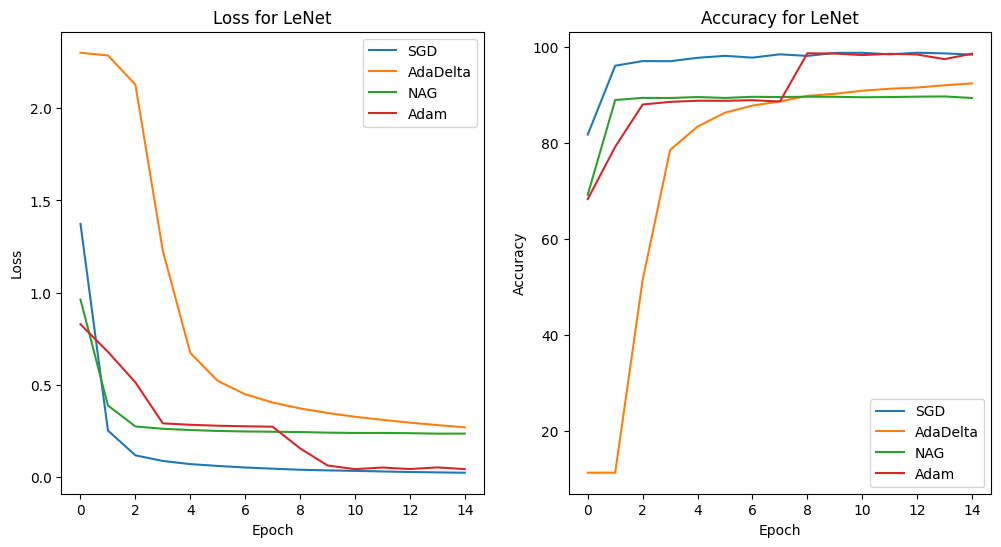

In [51]:
plot_losses_and_accuracy("LeNet", all_optimizer_names, all_loss_histories, all_accuracy_histories)
plt.show()

### CIFAR-10

In [52]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root="./CIFAR10", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Optimizers

In [87]:
optimizers = {
    "SGD": lambda model : optim.SGD(model.parameters(), lr=7e-3),
    "AdaDelta":  lambda model : optim.Adadelta(model.parameters(), lr=1.0,rho=0.9),
    "NAG":  lambda model : optim.SGD(model.parameters(), lr=3e-4, momentum=0.9, nesterov=True),
    "Adam":  lambda model : optim.Adam(model.parameters(), lr=4e-4)
}

In [55]:
criterion = nn.CrossEntropyLoss()

def train_optimizer(optimizer_name, modelclass):
    optimizer = optimizers.get(optimizer_name)
    print(f"Training with {optimizer_name} optimizer")
    model = modelclass.to(device)
    train_losses, accuracy_history = train_model(model, criterion, optimizer(model), num_epochs=15)
    if optimizer_name == "SGD":
        index = 0
    elif optimizer_name == "AdaDelta":
        index = 1
    elif optimizer_name == "NAG":
        index = 2
    elif optimizer_name == "Adam":
        index = 3
    all_loss_histories[index] = train_losses
    all_accuracy_histories[index] = accuracy_history
    all_optimizer_names[index] = optimizer_name
    accuracy = accuracy_history[-1]
    print(f"{optimizer_name} optimizer, final accuracy: {accuracy:.2f}%\n")

all_loss_histories = [None, None, None, None]
all_accuracy_histories = [None, None, None, None]
all_optimizer_names = [None, None, None, None]

### Train VGG16

In [77]:
train_optimizer("SGD", VGG16())

Training with SGD optimizer


Epoch №1, loss: 1.4131, accuracy: 56.58%, time spent: 125.57s
Epoch №2, loss: 1.0026, accuracy: 65.97%, time spent: 109.60s
Epoch №3, loss: 0.7993, accuracy: 71.23%, time spent: 100.17s
Epoch №4, loss: 0.6573, accuracy: 72.36%, time spent: 101.34s
Epoch №5, loss: 0.5399, accuracy: 73.96%, time spent: 102.84s
Epoch №6, loss: 0.4305, accuracy: 74.40%, time spent: 103.39s
Epoch №7, loss: 0.3300, accuracy: 73.59%, time spent: 104.46s
Epoch №8, loss: 0.2362, accuracy: 74.06%, time spent: 105.06s
Epoch №9, loss: 0.1554, accuracy: 74.08%, time spent: 105.45s
Epoch №10, loss: 0.0942, accuracy: 74.65%, time spent: 105.86s
Epoch №11, loss: 0.0547, accuracy: 74.80%, time spent: 102.57s
Epoch №12, loss: 0.0203, accuracy: 75.31%, time spent: 91.13s
Epoch №13, loss: 0.0065, accuracy: 76.13%, time spent: 91.42s
Epoch №14, loss: 0.0024, accuracy: 76.32%, time spent: 91.46s
Epoch №15, loss: 0.0014, accuracy: 76.40%, time spent: 91.73s
SGD optimizer, final accuracy: 76.40%



In [59]:
train_optimizer("AdaDelta", VGG16())

Training with AdaDelta optimizer


Epoch №1, loss: 1.1692, accuracy: 71.37%, time spent: 143.14s
Epoch №2, loss: 0.7769, accuracy: 73.62%, time spent: 135.50s
Epoch №3, loss: 0.5433, accuracy: 77.24%, time spent: 134.10s
Epoch №4, loss: 0.3697, accuracy: 78.91%, time spent: 109.01s
Epoch №5, loss: 0.2230, accuracy: 77.15%, time spent: 93.77s
Epoch №6, loss: 0.1323, accuracy: 78.70%, time spent: 94.03s
Epoch №7, loss: 0.0932, accuracy: 77.67%, time spent: 93.35s
Epoch №8, loss: 0.0764, accuracy: 77.60%, time spent: 93.74s
Epoch №9, loss: 0.0626, accuracy: 78.34%, time spent: 93.81s
Epoch №10, loss: 0.0501, accuracy: 78.76%, time spent: 93.99s
Epoch №11, loss: 0.0453, accuracy: 77.85%, time spent: 93.77s
Epoch №12, loss: 0.0414, accuracy: 78.60%, time spent: 94.75s
Epoch №13, loss: 0.0323, accuracy: 78.96%, time spent: 95.79s
Epoch №14, loss: 0.0338, accuracy: 78.50%, time spent: 97.79s
Epoch №15, loss: 0.0341, accuracy: 78.52%, time spent: 98.84s
AdaDelta optimizer, final accuracy: 78.52%



In [60]:
train_optimizer("NAG", VGG16())

Training with NAG optimizer


Epoch №1, loss: 1.3147, accuracy: 65.64%, time spent: 92.35s
Epoch №2, loss: 0.7658, accuracy: 74.63%, time spent: 86.39s
Epoch №3, loss: 0.5424, accuracy: 76.72%, time spent: 85.89s
Epoch №4, loss: 0.3818, accuracy: 76.25%, time spent: 85.77s
Epoch №5, loss: 0.2483, accuracy: 76.95%, time spent: 85.68s
Epoch №6, loss: 0.1762, accuracy: 75.41%, time spent: 85.69s
Epoch №7, loss: 0.1206, accuracy: 76.30%, time spent: 85.46s
Epoch №8, loss: 0.0842, accuracy: 77.20%, time spent: 85.92s
Epoch №9, loss: 0.0648, accuracy: 78.39%, time spent: 86.62s
Epoch №10, loss: 0.0497, accuracy: 77.41%, time spent: 85.92s
Epoch №11, loss: 0.0418, accuracy: 77.37%, time spent: 86.62s
Epoch №12, loss: 0.0457, accuracy: 78.09%, time spent: 86.93s
Epoch №13, loss: 0.0330, accuracy: 76.94%, time spent: 88.26s
Epoch №14, loss: 0.0363, accuracy: 78.00%, time spent: 88.12s
Epoch №15, loss: 0.0302, accuracy: 77.63%, time spent: 88.71s
NAG optimizer, final accuracy: 77.63%



In [88]:
train_optimizer("Adam", VGG16())

Training with Adam optimizer


Epoch №1, loss: 1.2268, accuracy: 65.52%, time spent: 121.40s
Epoch №2, loss: 0.8240, accuracy: 73.42%, time spent: 111.51s
Epoch №3, loss: 0.6124, accuracy: 73.85%, time spent: 110.21s
Epoch №4, loss: 0.4666, accuracy: 75.81%, time spent: 107.58s
Epoch №5, loss: 0.3153, accuracy: 76.47%, time spent: 105.66s
Epoch №6, loss: 0.1653, accuracy: 77.21%, time spent: 107.35s
Epoch №7, loss: 0.1088, accuracy: 76.62%, time spent: 108.61s
Epoch №8, loss: 0.0657, accuracy: 77.07%, time spent: 108.37s
Epoch №9, loss: 0.0772, accuracy: 76.28%, time spent: 107.44s
Epoch №10, loss: 0.0647, accuracy: 76.53%, time spent: 109.80s
Epoch №11, loss: 0.1262, accuracy: 76.99%, time spent: 108.57s
Epoch №12, loss: 0.0350, accuracy: 77.23%, time spent: 112.73s
Epoch №13, loss: 0.0226, accuracy: 77.35%, time spent: 116.29s
Epoch №14, loss: 0.0378, accuracy: 75.07%, time spent: 108.74s
Epoch №15, loss: 0.1252, accuracy: 76.80%, time spent: 110.88s
Adam optimizer, final accuracy: 76.80%



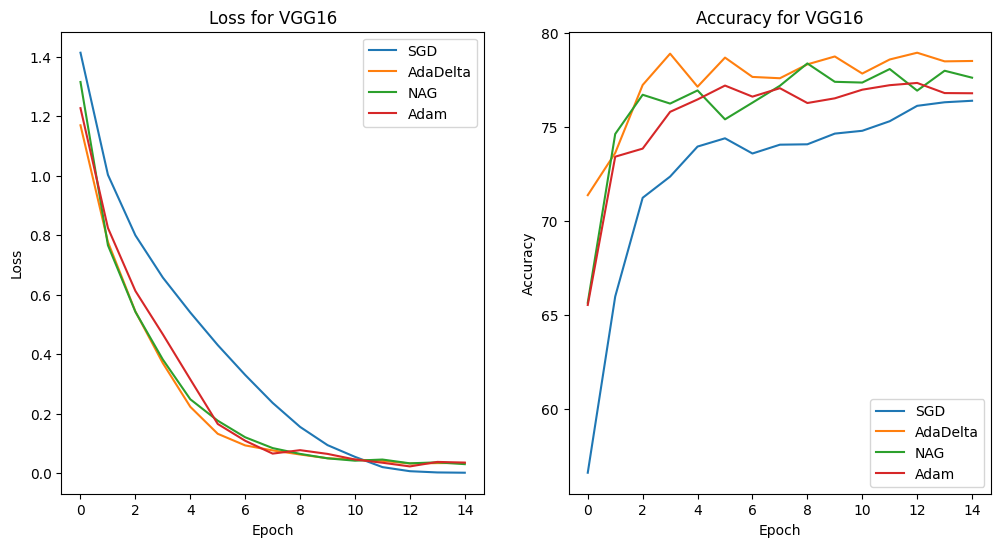

In [100]:
plot_losses_and_accuracy("VGG16", all_optimizer_names, all_loss_histories, all_accuracy_histories)
plt.show()

### CIFAR-100

In [6]:
transform = torchvision.transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.CIFAR100(root='CIFAR100/', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR100(root='CIFAR100/', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Optimizers

In [9]:
optimizers = {
    "SGD": lambda model : optim.SGD(model.parameters(), lr=8e-3),
    "AdaDelta":  lambda model : optim.Adadelta(model.parameters(), lr=1.0,rho=0.9),
    "NAG":  lambda model : optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, nesterov=True),
    "Adam":  lambda model : optim.Adam(model.parameters(), lr=2.5e-4)
}

In [7]:
criterion = nn.CrossEntropyLoss()

def train_optimizer(optimizer_name, modelclass):
    optimizer = optimizers.get(optimizer_name)
    print(f"Training with {optimizer_name} optimizer")
    model = modelclass.to(device)
    train_losses, accuracy_history = train_model(model, criterion, optimizer(model), num_epochs=12)
    if optimizer_name == "SGD":
        index = 0
    elif optimizer_name == "AdaDelta":
        index = 1
    elif optimizer_name == "NAG":
        index = 2
    elif optimizer_name == "Adam":
        index = 3
    all_loss_histories[index] = train_losses
    all_accuracy_histories[index] = accuracy_history
    all_optimizer_names[index] = optimizer_name
    accuracy = accuracy_history[-1]
    print(f"{optimizer_name} optimizer, final accuracy: {accuracy:.2f}%\n")

all_loss_histories = [None, None, None, None]
all_accuracy_histories = [None, None, None, None]
all_optimizer_names = [None, None, None, None]

### Train ResNet

In [10]:
train_optimizer("SGD", Resnet())

Training with SGD optimizer
Epoch №1, loss: 4.3009, accuracy: 10.13%, time spent: 942.54s
Epoch №2, loss: 3.8578, accuracy: 16.05%, time spent: 667.21s
Epoch №3, loss: 3.3220, accuracy: 18.04%, time spent: 646.89s
Epoch №4, loss: 3.0252, accuracy: 22.26%, time spent: 665.30s
Epoch №5, loss: 2.7724, accuracy: 23.08%, time spent: 597.97s
Epoch №6, loss: 2.5576, accuracy: 26.21%, time spent: 596.53s
Epoch №7, loss: 2.3467, accuracy: 33.18%, time spent: 611.89s
Epoch №8, loss: 2.1511, accuracy: 23.64%, time spent: 651.69s
Epoch №9, loss: 1.9549, accuracy: 32.92%, time spent: 663.43s
Epoch №10, loss: 1.7536, accuracy: 30.32%, time spent: 591.02s
Epoch №11, loss: 1.5457, accuracy: 33.27%, time spent: 593.69s
Epoch №12, loss: 1.3300, accuracy: 32.47%, time spent: 683.51s
SGD optimizer, final accuracy: 32.47%



In [ ]:
train_optimizer("AdaDelta", Resnet())

Training with AdaDelta optimizer
Epoch №1, loss: 3.7762, accuracy: 11.90%, time spent: 45.97s
Epoch №2, loss: 3.4005, accuracy: 19.39%, time spent: 44.72s
Epoch №3, loss: 2.8788, accuracy: 23.55%, time spent: 44.19s
Epoch №4, loss: 2.5784, accuracy: 29.68%, time spent: 44.58s
Epoch №5, loss: 2.3280, accuracy: 27.87%, time spent: 44.75s
Epoch №6, loss: 2.0936, accuracy: 36.49%, time spent: 44.81s
Epoch №7, loss: 1.8621, accuracy: 33.58%, time spent: 44.13s
Epoch №8, loss: 1.6309, accuracy: 35.87%, time spent: 44.47s
Epoch №9, loss: 1.4004, accuracy: 34.63%, time spent: 44.68s
Epoch №10, loss: 1.1759, accuracy: 36.38%, time spent: 45.39s
Epoch №11, loss: 0.9614, accuracy: 35.31%, time spent: 44.77s
Epoch №12, loss: 0.7796, accuracy: 35.50%, time spent: 44.76s
Epoch №13, loss: 0.6270, accuracy: 34.55%, time spent: 44.90s
Epoch №14, loss: 0.5097, accuracy: 35.08%, time spent: 45.16s
Epoch №15, loss: 0.4177, accuracy: 34.94%, time spent: 44.97s
AdaDelta optimizer, final accuracy: 34.94%



In [ ]:
train_optimizer("NAG", Resnet())

Training with NAG optimizer
Epoch №1, loss: 3.8056, accuracy: 18.31%, time spent: 45.88s
Epoch №2, loss: 3.5516, accuracy: 21.99%, time spent: 44.85s
Epoch №3, loss: 2.9379, accuracy: 26.75%, time spent: 44.56s
Epoch №4, loss: 2.6287, accuracy: 29.04%, time spent: 44.68s
Epoch №5, loss: 2.3764, accuracy: 35.31%, time spent: 44.35s
Epoch №6, loss: 2.1552, accuracy: 35.41%, time spent: 44.71s
Epoch №7, loss: 1.9559, accuracy: 38.50%, time spent: 44.48s
Epoch №8, loss: 1.7775, accuracy: 38.67%, time spent: 44.51s
Epoch №9, loss: 1.5900, accuracy: 39.55%, time spent: 44.09s
Epoch №10, loss: 1.4137, accuracy: 38.83%, time spent: 44.49s
Epoch №11, loss: 1.2554, accuracy: 39.78%, time spent: 44.59s
Epoch №12, loss: 1.1001, accuracy: 38.99%, time spent: 44.57s
Epoch №13, loss: 0.9632, accuracy: 38.26%, time spent: 44.12s
Epoch №14, loss: 0.8488, accuracy: 38.16%, time spent: 44.22s
Epoch №15, loss: 0.7321, accuracy: 37.31%, time spent: 44.44s
NAG optimizer, final accuracy: 37.31%



In [ ]:
train_optimizer("Adam", Resnet())

Training with Adam optimizer
Epoch №1, loss: 4.0123, accuracy: 18.30%, time spent: 46.30s
Epoch №2, loss: 3.1832, accuracy: 27.07%, time spent: 44.33s
Epoch №3, loss: 2.6552, accuracy: 33.92%, time spent: 44.59s
Epoch №4, loss: 2.2935, accuracy: 36.69%, time spent: 44.77s
Epoch №5, loss: 1.9578, accuracy: 40.00%, time spent: 44.54s
Epoch №6, loss: 1.6209, accuracy: 39.77%, time spent: 43.95s
Epoch №7, loss: 1.2547, accuracy: 38.80%, time spent: 44.30s
Epoch №8, loss: 0.9102, accuracy: 38.81%, time spent: 44.49s
Epoch №9, loss: 0.6226, accuracy: 37.76%, time spent: 44.31s
Epoch №10, loss: 0.4199, accuracy: 37.23%, time spent: 45.15s
Epoch №11, loss: 0.3129, accuracy: 37.31%, time spent: 45.81s
Epoch №12, loss: 0.2487, accuracy: 36.92%, time spent: 45.55s
Epoch №13, loss: 0.2120, accuracy: 37.07%, time spent: 44.68s
Epoch №14, loss: 0.1911, accuracy: 36.26%, time spent: 44.36s
Epoch №15, loss: 0.1679, accuracy: 37.10%, time spent: 44.39s
Adam optimizer, final accuracy: 37.10%



[4.3008, 3.8577, 3.3219, 3.0251, 2.7724, 2.5575, 2.3466, 2.1511, 1.9548, 1.7535, 1.5456, 1.3299]
[3.7762, 3.4005, 2.8788, 2.5784, 2.328, 2.0936, 1.8621, 1.6309, 1.4004, 1.1759, 0.9614, 0.7796]
[3.8056, 3.5516, 2.9379, 2.6287, 2.3764, 2.1552, 1.9559, 1.7775, 1.59, 1.4137, 1.2554, 1.1001]
[4.0123, 3.1832, 2.6552, 1.9578, 1.6209, 1.2547, 0.9102, 0.6226, 0.4199, 0.3129, 0.2487, 0.212]

[10.13, 16.05, 18.04, 22.26, 23.08, 26.21, 33.18, 29.64, 32.92, 32.32, 33.27, 32.47]
[11.9, 19.39, 23.55, 29.68, 27.87, 36.49, 33.58, 35.87, 34.63, 36.38, 35.31, 35.5]
[18.31, 21.99, 26.75, 29.04, 35.31, 35.41, 38.5, 38.67, 39.55, 38.83, 39.78, 38.99]
[19.3, 27.07, 33.92, 36.69, 40.0, 39.77, 38.8, 38.81, 37.76, 37.23, 37.31, 36.92]


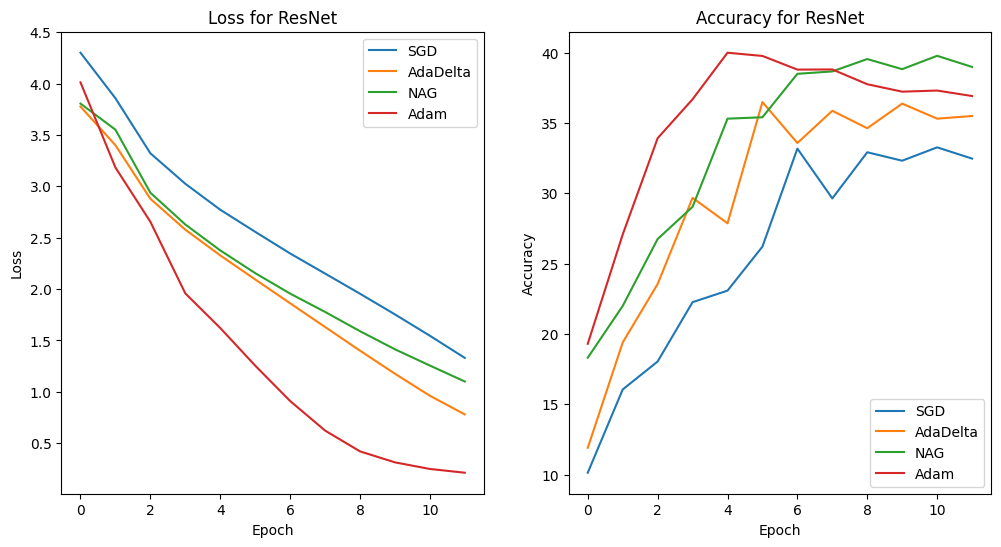

In [20]:
# сохраняю результаты чтобы не потерялись при перезапуске ячейки нотбука
all_loss_histories[0] = [4.3008, 3.8577, 3.3219, 3.0251, 2.7724, 2.5575, 2.3466, 2.1511, 1.9548, 1.7535, 1.5456, 1.3299]
all_accuracy_histories[0] = [10.13, 16.05, 18.04, 22.26, 23.08, 26.21, 33.18, 29.64, 32.92, 32.32, 33.27, 32.47]

all_loss_histories[1] = [3.7762, 3.4005, 2.8788, 2.5784, 2.3280, 2.0936, 1.8621, 1.6309, 1.4004, 1.1759, 0.9614, 0.7796]
all_accuracy_histories[1] = [11.9, 19.39, 23.55, 29.68, 27.87, 36.49, 33.58, 35.87, 34.63, 36.38, 35.31, 35.50]

all_loss_histories[2] = [3.8056, 3.5516, 2.9379, 2.6287, 2.3764, 2.1552, 1.9559, 1.7775, 1.5900, 1.4137, 1.2554, 1.1001]
all_accuracy_histories[2] = [18.31, 21.99, 26.75, 29.04, 35.31, 35.41, 38.50, 38.67, 39.55, 38.83, 39.78, 38.99]

all_loss_histories[3] = [4.0123, 3.1832, 2.6552, 1.9578, 1.6209, 1.2547, 0.9102, 0.6226, 0.4199, 0.3129, 0.2487, 0.2120]
all_accuracy_histories[3] = [19.30, 27.07, 33.92, 36.69, 40.00, 39.77, 38.80, 38.81, 37.76, 37.23, 37.31, 36.92]

all_optimizer_names[0] = "SGD"
all_optimizer_names[1] = "AdaDelta"
all_optimizer_names[2] = "NAG"
all_optimizer_names[3] = "Adam"

print(all_loss_histories[0])
print(all_loss_histories[1])
print(all_loss_histories[2])
print(all_loss_histories[3])
print()
print(all_accuracy_histories[0])
print(all_accuracy_histories[1])
print(all_accuracy_histories[2])
print(all_accuracy_histories[3])

plot_losses_and_accuracy("ResNet", all_optimizer_names, all_loss_histories, all_accuracy_histories)
plt.show()